In [1]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt
import matplotlib.pyplot as plt

## The problem

* 100 students took an exam and interviewed afterwards
* In the interview they tossed a coin.
* If they toss heads they answer honestly whether they cheated or not
* If they toss tails they must toss again & and answer "Yes I cheated" if the second toss is heads, and "No I didn't cheat" if it's tails.
* We received `35` "Yes I cheated" answers

## 1. Designing the data generation scheme

*...what is the best way to describe the data with random variables?*

The "cheating status" of a student can be modelled as Bernoulli random variable (2 possible outcomes where the probability of each outcome is `p` and `(1-p)` respectively)

$$\text{cheater} \sim \text{Bernoulli}(\mathit{p})$$

So we need to model `p` - the probability that a student is a cheater. We don't have any reason to make any assumptions about `p` so we use a Uniform random variable.

$$\text{p} \sim \text{Uniform}(\mathit{lower}=0.0,~\mathit{upper}=1.0)$$

Obviously the coin flips are modelled as Bernoulli random variables with equal probability of each outcome (assuming the coin is fare).

$$\text{first_flip} \sim \text{Bernoulli}(\mathit{p}=0.5)$$
$$\text{second_flip} \sim \text{Bernoulli}(\mathit{p}=0.5)$$

Because the values are being encoded as `zeros` and `ones` (`1 => cheater`, `0 => didn't cheat`, `1 => tossed a head`, `0 => tossed a tail`) we can determine the student's answer as:

$$\text{first_flip} \times \text{cheater} + (1-\text{first_flip}) \times \text{second_flip}$$

**Notes:**

* I'm not sure why we're setting `testval` on each of the Bernoulli variables. I *think* it's just to give it a more realistic starting point. It looks like if we don't set it, it start off as `[0,0,0,...,0]`.
* A binomial variable with `1` trial is equivalent to a Bernoulli variable - I guess numpy doesn't have a separate `np.random.bernoulli` function.
* `answers` is a `TensorVariable`. I guess it's an example of an *implicit* deterministic variable but I'm not sure yet I fully understand when you would choose to make an explicit one. My notes say something like implicit ones "don't get tracked by the sampling".
* `yes_answers_proportion` is the proportion of "yes I cheated" answers. This is created *explicitly* as a deterministic variable.

In [3]:
N=100
with pm.Model() as model:
    p = pm.Uniform('p', 0, 1)
    cheaters = pm.Bernoulli('cheaters', p, shape=N, testval=np.random.binomial(1, 0.5, N))
    first_coin_flips = pm.Bernoulli('first_flips', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
    second_coin_flips = pm.Bernoulli('second_flips', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
    answers = first_coin_flips*cheaters + (1-first_coin_flips)*second_coin_flips
    yes_answers_proportion = pm.Deterministic("yes_proportion", tt.sum(answers)/float(N))
    
yes_answers_proportion.tag.test_value

array(0.49000001)

## 2. Associate the data generation scheme with the actual observed data

$$\text{observations} \sim \text{Binomial}(\mathit{n}=100,~\mathit{p}=\text{yes_proportion})$$

In [3]:
with model:
    observations = pm.Binomial("observations", N, yes_answers_proportion, observed=35)

## 3. Run the (up to now) black-box algorithm over the model

In [4]:
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p]
>BinaryGibbsMetropolis: [cheaters, first_flips, second_flips]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████| 162000/162000 [21:26<00:00, 125.95draws/s]
The number of effective samples is smaller than 10% for some parameters.


## 4. Investigate and interpret the posterior distribution

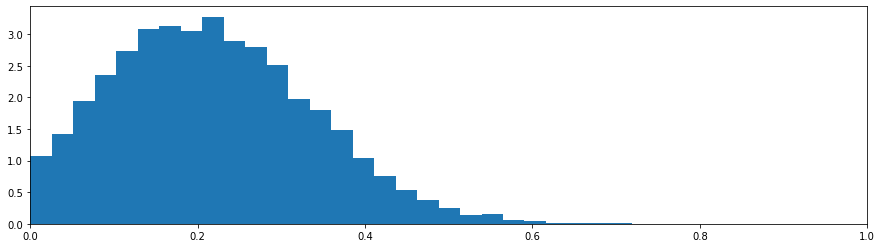

In [5]:
plt.figure(figsize=(15,4))
plt.hist(burned_trace["p"][15000:], bins=30, density=True)
plt.xlim(0, 1);

* The posterior is quite a wide distribution so we're pretty uncertain about the proportion of cheaters. Possibly between 0.05 & 0.35?
* BUT, we can say it's quite unlikely that there are no cheaters - it's a fairly low value for $p=0$

## An alternative model

The probability that a student will answer yes:

$$P(\text{"Yes"})=P(\text{Heads on first toss}) \times P(\text{cheater}) + P(\text{Tails on first toss}) \times P(\text{Heads on second toss})$$

$$=\frac{1}{2} \times p + \frac{1}{2} \times \frac{1}{2}$$

$$=\frac{p}{2} + \frac{1}{4}$$

So, we can make a deterministic variable from $p$ to give us the probability that student will answer "Yes" and use that as the input to our Binomial variable to model the observations...

$$\text{observations} \sim \text{Binomial}(\mathit{n}=100,~\mathit{p}=P(\text{"Yes"}))$$

In [12]:
with pm.Model() as alternative_model:
    p = pm.Uniform('p', 0, 1)
    p_yes = pm.Deterministic("p_yes", 0.5*p + 0.25)
    observations = pm.Binomial("observations", N, p_yes, observed=35)
    
    step = pm.Metropolis()
    trace = pm.sample(25000, step=step)
    alt_burned_trace = trace[2500:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████| 102000/102000 [00:37<00:00, 2710.87draws/s]
The number of effective samples is smaller than 25% for some parameters.


...which runs much faster & gives a similar result...

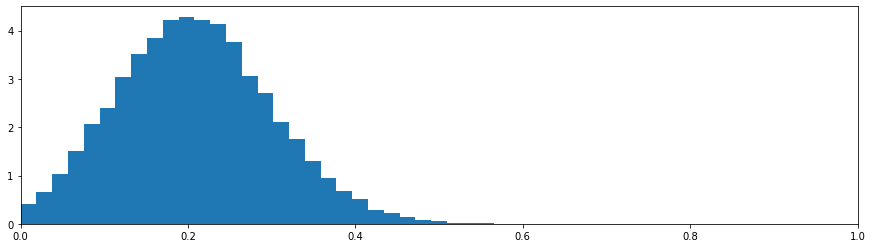

In [13]:
plt.figure(figsize=(15,4))
plt.hist(alt_burned_trace["p"][15000:], bins=30, density=True)
plt.xlim(0, 1);